In [1]:
def clean_nulls(df):
    indexes_with_nulls = df[df.isnull().any(axis=1)].index
    for index in indexes_with_nulls:
        df.loc[index,'descriptions'] = df.loc[index]['comment_number'].split('  ')[1]
        df.loc[index,'comment_number'] = df.loc[index]['comment_number'].split('   ')[0]
    df.drop(columns=['comment_number'], inplace=True)
    return df

In [2]:
import re
import string

def preprocess_descriptions(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = 'startseq '+text+' endseq'
    return text

In [3]:
def preprocess_df(df):
    new_column_names = {' comment_number':'comment_number', ' comment': 'descriptions'}
    df.rename(columns=new_column_names, inplace=True)
    df = clean_nulls(df)
    df['descriptions'] = df['descriptions'].apply(preprocess_descriptions)
    return df

In [4]:
def mapping_images_with_descriptions(df):
    df = df.groupby('image_name')['descriptions'].agg(list).reset_index()
    return df

In [5]:
# Extract Features
from keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model

# VGG16 Model
VGG16_model = VGG16()
VGG16_model = Model(inputs = VGG16_model.inputs, outputs = VGG16_model.layers[-2].output) 
VGG16_model.summary()

2024-03-05 20:22:48.045291: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 20:22:48.045427: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-05 20:22:48.224460: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


553467096/553467096 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [6]:
from pickle import dump

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input 
from keras.models import Model

def extract_features(image_path):
    image = load_img(image_path, target_size=(224,224))
    image = img_to_array(image)
    image = image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
    image = preprocess_input(image)
    feature = VGG16_model.predict(image, verbose=1)
    return feature

In [7]:
import os
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import torch
from skimage import io

class flickerImagesDataset(Dataset):
    def __init__(self, csv_file, root_dir):
        self.df = pd.read_csv(csv_file, sep='|')
        self.df = preprocess_df(self.df)
        self.df = mapping_images_with_descriptions(self.df)
        self.root_dir = root_dir

    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.df.iloc[index, 0])
        feature = extract_features(img_path)
        descriptions = self.df.iloc[index]['descriptions']
        return (feature, descriptions)

In [8]:
dataset = flickerImagesDataset(
            csv_file = '/kaggle/input/flickr-image-dataset/flickr30k_images/results.csv',
            root_dir = '/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/',
        )

In [9]:
dataset

In [10]:
data_length = dataset.__len__()
data_length

31783

In [11]:
import pandas as pd

# Count of unique values
unique_count = dataset.df['image_name'].nunique()

print(f"Unique: {unique_count}")

Unique: 31783


In [12]:
descriptions = dataset.df['descriptions']
descriptions[2553]

['startseq a man wearing a shirt with an animal pattern on it and a purple tie is singing in a microphone endseq',
 'startseq a brownhaired man in a patterned shirt and purple tie is singing into a microphone endseq',
 'startseq a man with a purple tie is singing into a microphone endseq',
 'startseq a very happy singer in an extravagant outfit endseq',
 'startseq a man in purple tie is singing endseq']

In [13]:
dataset.df.columns

Index(['image_name', 'descriptions'], dtype='object')

In [14]:
# Flatten the list of lists into a single list
all_descriptions = [description for sublist in descriptions for description in sublist]

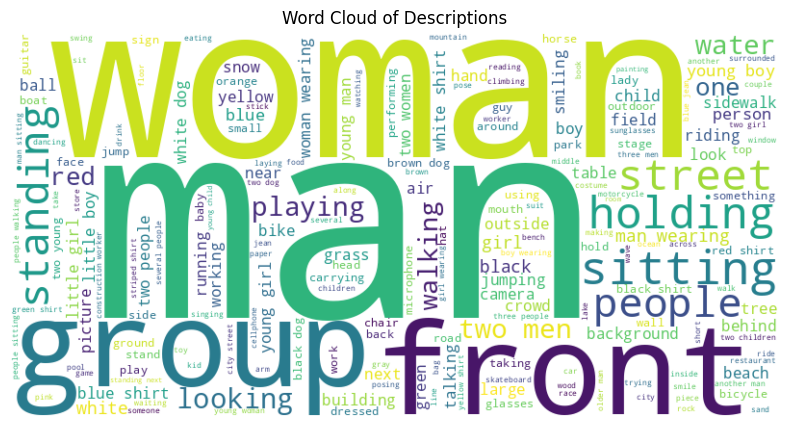

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Join all descriptions into a single string and remove 'startseq' and 'endseq'
all_descriptions_text = ' '.join([desc.replace('startseq', '').replace('endseq', '') for desc in all_descriptions])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_descriptions_text)

# Plot word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Descriptions')
plt.show()

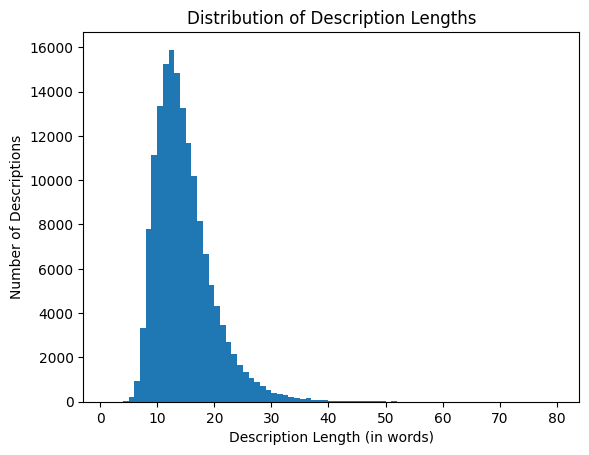

In [16]:
import matplotlib.pyplot as plt

# Calculate the lengths of descriptions
descriptions_length = [len(desc.split()) for desc in all_descriptions]

# Plot a histogram
plt.hist(descriptions_length, bins=range(1, max(descriptions_length) + 1))
plt.xlabel('Description Length (in words)')
plt.ylabel('Number of Descriptions')
plt.title('Distribution of Description Lengths')
plt.show()

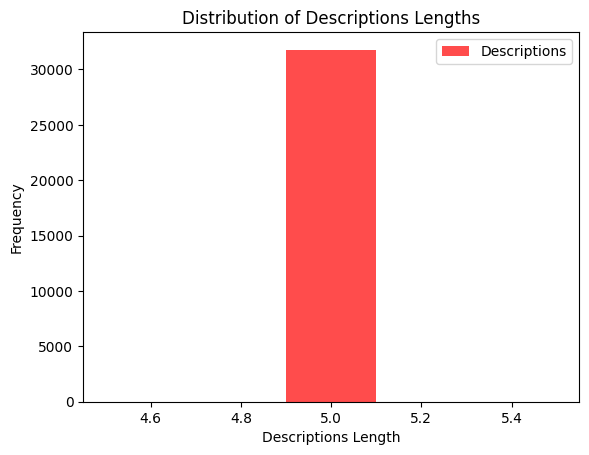

In [17]:
import matplotlib.pyplot as plt

images_des_numder = [len(descriptions) for descriptions in dataset.df["descriptions"]]
plt.hist(images_des_numder, bins=5, color='red', alpha=0.7, label='Descriptions')
plt.xlabel('Descriptions Length')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Descriptions Lengths')
plt.show()

In [18]:
print("Data Size:",data_length)

Data Size: 31783


In [19]:
import math 

train_size = math.ceil(data_length*0.6)
val_size = math.ceil(data_length*0.2)
test_size = math.floor(data_length*0.2)

In [20]:
print("Train size:",train_size)
print("Val size:",val_size)
print("Test size:",test_size)

Train size: 19070
Val size: 6357
Test size: 6356


In [21]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

train_set, val_set, test_set = torch.utils.data.random_split(
                                                                dataset,
                                                                [train_size,val_size,test_size]
                                                            )

In [22]:
len(train_set),len(val_set),len(test_set)

(19070, 6357, 6356)

In [23]:
train_set[0]

1/1 [==============================] - 3s 3s/step


(array([[0.       , 1.6776022, 3.2568755, ..., 0.       , 0.       ,
         3.71275  ]], dtype=float32),
 ['startseq a man in a red black and white uniform is pursuing a soccer ball on a grassy field endseq',
  'startseq a soccer player in a red uniform is about to kick the ball endseq',
  'startseq a professional soccer player about to kick a soccer ball endseq',
  'startseq a soccer player is getting ready to kick the ball endseq',
  'startseq soccer player in red about to kick a ball endseq'])

In [24]:
from keras.preprocessing.text import Tokenizer 

# Create tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_descriptions)

# Vocabulary size
vocab_size = len(tokenizer.word_index) + 1
max_length = max(descriptions_length)

In [25]:
max_length,vocab_size

(80, 19775)

In [26]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np

def data_generator(data, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    size = 0
    for sample in data:
        size+=1
        for des in sample[1]:
            seq = tokenizer.texts_to_sequences([des])[0]
            # Split the sequence into X, y pairs
            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                # Pad input sequence
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                # Encode output sequence
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                # Store the sequences
                X1.append(sample[0][0])  # Assuming img is the image features
                X2.append(in_seq)
                y.append(out_seq)
        if size == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                size = 0

In [27]:
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

LSTM_model = Model(inputs=[inputs1, inputs2], outputs=outputs)
LSTM_model.compile(loss='categorical_crossentropy', optimizer='adam')

In [28]:
LSTM_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 80)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 4096)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 80, 256)              5062400   ['input_3[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 4096)                 0         ['input_2[0][0]']             
                                                                                            

In [29]:
# train the model
epochs = 1
batch_size = 128
steps = len(train_set) // batch_size

for i in range(epochs):
    # create data generator
    train_generator = data_generator(train_set, tokenizer, max_length, vocab_size, batch_size)
    val_generator = data_generator(val_set, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    LSTM_model.fit(train_generator,
                   epochs=1,
                   steps_per_epoch=steps,
                   verbose=1,
                   validation_data=val_generator
                  )

1/1 [==============================] - 0s 36ms/step


I0000 00:00:1709670238.309991      70 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


148/148 [==============================] - 2752s 19s/step - loss: 5.3383 - val_loss: 4.3727


In [30]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [31]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [32]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for image_descriptions in test_set:
    # predict the caption for image
    y_pred = predict_caption(LSTM_model, image_descriptions[0], tokenizer, max_length) 
    # split into words
    actual_descriptions = [description.split() for description in image_descriptions[1]]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_descriptions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

1/1 [==============================] - 0s 19ms/step
BLEU-1: 0.175183
BLEU-2: 0.111197
